<a href="https://colab.research.google.com/github/Nethmi-Randi/AudioVideoSentimentAnalysis/blob/main/imageSentimentAnalysisModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length "{length}" bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length "63252113" bytes


In [ ]:
from zipfile import ZipFile
file_name = "archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Activation
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Add, concatenate
from tensorflow.keras.models import Model
import os
import shutil

In [ ]:
# Data directories
train_dir = 'train'
test_dir = 'test'
val_data_dir = 'val_data'
if not os.path.exists(val_data_dir):
    os.makedirs(val_data_dir)

# Function to split train data into training and validation sets (10% validation)
def split_train_val(train_dir, val_dir, val_split=0.2):
    for class_dir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_dir)
        val_class_path = os.path.join(val_dir, class_dir)
        if not os.path.exists(val_class_path):
            os.makedirs(val_class_path)

        files = os.listdir(class_path)
        np.random.shuffle(files)
        val_size = int(len(files) * val_split)
        val_files = files[:val_size]

        for val_file in val_files:
            src_path = os.path.join(class_path, val_file)
            dst_path = os.path.join(val_class_path, val_file)
            shutil.move(src_path, dst_path)

split_train_val(train_dir, val_data_dir, val_split=0.2)

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

print(f'Found {train_generator.samples} images belonging to {train_generator.num_classes} classes in the training set.')
print(f'Found {validation_generator.samples} images belonging to {validation_generator.num_classes} classes in the validation set.')
print(f'Found {test_generator.samples} images belonging to {test_generator.num_classes} classes in the test set.')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 22968 images belonging to 7 classes in the training set.
Found 5741 images belonging to 7 classes in the validation set.
Found 7178 images belonging to 7 classes in the test set.


Proposed CNN Architecture with advanced deep learning techniques

In [ ]:

# Squeeze-and-Excitation block
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input_tensor, se])
    return se

# Residual block
def residual_block(x, filters, kernel_size=3):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = BatchNormalization()(res)
    x = Add()([x, res])
    return Activation('relu')(x)

# Inception module
def inception_module(x, filters):
    conv1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    conv5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    return concatenate([conv1, conv3, conv5], axis=-1)

input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)

emotion_model = Sequential()

# First Convolutional Block with Residual Connection
x = Conv2D(64, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([inputs, x])
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Second Convolutional Block with Attention Mechanism
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Third Convolutional Block with Inception Module
x = inception_module(x, 128)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Fourth Convolutional Block with Residual and Attention Mechanism
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, residual_block(x, 256)])
x = tf.keras.layers.Attention()([x, x])
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Global Average Pooling and Fully Connected Layers
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
outputs = Dense(7, activation='softmax')(x)

emotion_model = Model(inputs, outputs)


In [ ]:
emotion_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=22968 // 64,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=5741 // 64)


Epoch 1/100


<ipython-input-6-8da81a34abb8>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


448/448 [==============================] - 29s 42ms/step - loss: 2.1946 - accuracy: 0.2105 - val_loss: 1.9036 - val_accuracy: 0.2472
Epoch 2/100
448/448 [==============================] - 18s 40ms/step - loss: 2.0249 - accuracy: 0.2448 - val_loss: 1.7741 - val_accuracy: 0.3023
Epoch 3/100
448/448 [==============================] - 18s 39ms/step - loss: 1.8877 - accuracy: 0.2872 - val_loss: 1.6717 - val_accuracy: 0.3417
Epoch 4/100
448/448 [==============================] - 18s 41ms/step - loss: 1.7703 - accuracy: 0.3283 - val_loss: 1.6205 - val_accuracy: 0.3677
Epoch 5/100
448/448 [==============================] - 18s 41ms/step - loss: 1.6642 - accuracy: 0.3659 - val_loss: 1.5320 - val_accuracy: 0.3997
Epoch 6/100
448/448 [==============================] - 19s 42ms/step - loss: 1.5758 - accuracy: 0.3963 - val_loss: 1.4394 - val_accuracy: 0.4372
Epoch 7/100
448/448 [==============================] - 18s 40ms/step - loss: 1.5135 - accuracy: 0.4191 - val_loss: 1.4309 - val_accuracy: 0.43

In [ ]:
#Saving the model

from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/My Drive/models/Image.h5'
emotion_model.save(save_path)
print(f"Model saved successfully at {save_path}")


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at /content/drive/My Drive/models/Image.h5


In [ ]:
#load the model
from google.colab import drive
from keras.models import load_model
drive.mount('/content/drive')
load_path = '/content/drive/My Drive/models/Image.h5'
try:
    emotion_model = load_model(load_path)
    print("Model loaded successfully.")
    emotion_model.summary()
except Exception as e:
    print(f"Error loading model: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                     

Evaluate the model

Found 7178 images belonging to 7 classes.
112/112 [==============================] - 3s 25ms/step - loss: 1.4641 - accuracy: 0.6349
Test Loss: 1.464058518409729
Test Accuracy: 0.6349051594734192
113/113 [==============================] - 4s 30ms/step


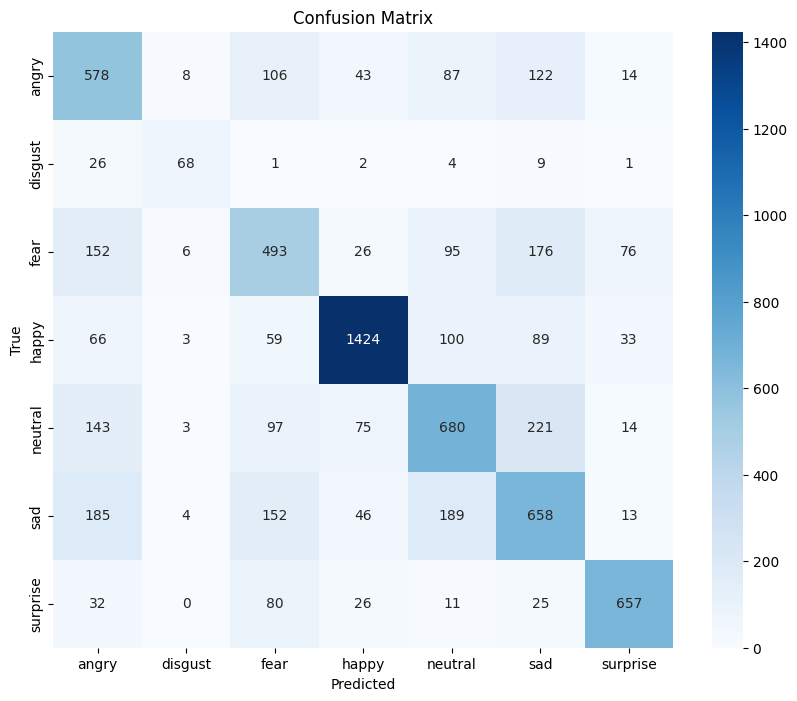

              precision    recall  f1-score   support

       angry       0.49      0.60      0.54       958
     disgust       0.74      0.61      0.67       111
        fear       0.50      0.48      0.49      1024
       happy       0.87      0.80      0.83      1774
     neutral       0.58      0.55      0.57      1233
         sad       0.51      0.53      0.52      1247
    surprise       0.81      0.79      0.80       831

    accuracy                           0.63      7178
   macro avg       0.64      0.62      0.63      7178
weighted avg       0.64      0.63      0.64      7178



In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_dir = 'test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test set
test_loss, test_accuracy = emotion_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

test_generator.reset()
predictions = emotion_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Test the Image Sentiment Analysis model

In [ ]:
from google.colab import drive
from tensorflow.keras.preprocessing import image
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')


def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

# Path to the image in your Google Drive
test_img_path = '/content/drive/My Drive/d.jpg'

# Preprocess the image
preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')



In [ ]:
from google.colab import drive
from keras.models import load_model
drive.mount('/content/drive')
load_path = '/content/drive/My Drive/models/Image.h5'

Mounted at /content/drive


**Angry**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/models/Image.h5'

emotion_model = load_model(model_path)

from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

test_img_path = '/content/drive/My Drive/images/test/angry/PublicTest_99743122.jpg'

preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 158ms/step
Predicted emotion: Angry


**Surprise**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/models/Image.h5'

emotion_model = load_model(model_path)

from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

test_img_path = '/content/drive/My Drive/images/test/surprise/PublicTest_99446963.jpg'

preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 156ms/step
Predicted emotion: Surprise


**Sad**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/models/Image.h5'

emotion_model = load_model(model_path)

from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

test_img_path = '/content/drive/My Drive/images/test/sad/PublicTest_99741160.jpg'

preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 285ms/step
Predicted emotion: Sad


**Neutral**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/models/Image.h5'

emotion_model = load_model(model_path)

from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

test_img_path = '/content/drive/My Drive/images/test/neutral/PublicTest_99862107.jpg'

preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 0s 148ms/step
Predicted emotion: Neutral


**Happy**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/models/Image.h5'

emotion_model = load_model(model_path)

from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

test_img_path = '/content/drive/My Drive/images/test/happy/PublicTest_99849498.jpg'

preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 415ms/step
Predicted emotion: Happy


**Fear**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/models/Image.h5'

emotion_model = load_model(model_path)

from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

test_img_path = '/content/drive/My Drive/images/test/fear/PublicTest_99801821.jpg'

preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 217ms/step
Predicted emotion: Fear


**Disgust**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/models/Image.h5'

emotion_model = load_model(model_path)

from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

test_img_path = '/content/drive/My Drive/images/test/disgust/PublicTest_99162116.jpg'

preprocessed_img = preprocess_image(test_img_path)

prediction = emotion_model.predict(preprocessed_img)
emotion_label = np.argmax(prediction)
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_emotion = emotion_dict[emotion_label]
print(f'Predicted emotion: {predicted_emotion}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 159ms/step
Predicted emotion: Disgust
